In [1]:
import copy
import h5py
import itertools
import numpy as np
import os
import scipy
import scipy.interpolate
import tqdm

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import palettable

In [3]:
import yt
import trident
import unyt as u

In [4]:
import kalepy as kale
import verdict

In [5]:
import one_zone

# Parameters

In [6]:
# Analysis parameters
seed = 15482
rng = np.random.default_rng( seed )
verbose = False

In [7]:
# Data management parameters
distribution_fp = './data/EAGLE/histogram_galaxies_logM200c-Msun-12.0-12.5_200_seed0_hneutralssh.hdf5'
data_dir = './data/synthetic_data/sample1'
observer_data_dir = './data/synthetic_data_samples/sample1'

In [8]:
# Ray parameters
redshift = 0.25
n_sightlines = 100
min_clouds_per_sightline = 1
max_clouds_per_sightline = 3
velocity_range = [ -150., 150. ] # In km/s
finite_cloud_max_logT = 5 # We'll only allow one cloud per line of sight with temperatures greater than this

In [9]:
# Spectra parameters
ions = [
    'H I',
    'O I',
    'C II',
    'C III',
    'N II',
    'N III',
    'Si II',
    'Si III',
    'Si IV',
#     'N V',
    'O VI',
    'Mg II'
]
fields = [
    'H_p0_number_density', 
    'O_p0_number_density',
    'C_p1_number_density',
    'C_p2_number_density',
    'N_p1_number_density',
    'N_p2_number_density',
    'Si_p1_number_density',
    'Si_p2_number_density',
    'Si_p3_number_density',
#     'N_p4_number_density',
    'O_p5_number_density',
    'Mg_p1_number_density'
]
snr = 30

# Load Data

In [10]:
sls = verdict.Dict.from_hdf5( './data/synthetic_data/sample1/sightlines.h5', jagged_flag='sl')

In [11]:
clouds = {}
for key, item in sls.items():
    clouds[key] = np.concatenate( item )

In [12]:
# Objects for use
ldb = trident.LineDatabase('lines.txt')
sg_cos = trident.SpectrumGenerator('COS-G130M')

yt : [INFO     ] 2021-03-10 10:27:13,409 Setting instrument to COS-G130M


In [13]:
# Spectrum Generator for Mg II from ground
lambda_mg = ldb.select_lines( 'Mg', 'II' )[0].wavelength * ( 1. + redshift )
sg_mg = trident.SpectrumGenerator(
    lambda_min = lambda_mg - 15.,
    lambda_max = lambda_mg + 15.,
    dlambda = 0.01,
    lsf_kernel = os.path.join( trident.path, 'data', 'lsf_kernels', 'avg_COS.txt' ),
)

yt : [INFO     ] 2021-03-10 10:27:13,420 Setting instrument to Custom


# Investigate Individual Sightlines for Consistency

We'll take one individual sightline, regenerate it, make sure the regenerated spectra matches with what we gave modelers, and look at why the spectra looks as it does.

In [14]:
i = 4
sg = sg_mg

In [15]:
density = 10.**sls['Density'][i] * u.g * u.cm**-3
temperature = 10.**sls['Temperature'][i] * u.K
metallicity = 10.**sls['Metallicity'][i] * u.Zsun / 0.014
HI_column = 10.**sls['HI Column'][i] * u.cm**-2
velocity = sls['LOS Velocity'][i] * u.km / u.s

In [16]:
lengths_i = []
taus_i = []
for j, density_j in enumerate( density ):

    # First, let's create a one-zone dataset for our desired density,
    # temperature, metallicity, and redshift.  We'll arbitrarily set it to
    # be 1 kpc in width.  
    ds = trident.make_onezone_dataset(
        density = density[j],
        temperature = temperature[j],
        metallicity = metallicity[j],
        domain_width = 1.*u.kpc
    )
    ds.current_redshift = redshift

    # Now let's add our desired ions to this dataset, using Trident's 
    # lookup table based on the Haardt-Madau 2012 UV background.
    trident.add_ion_fields(ds, ions=ions)

    # Since we now know the HI number density for this dataset, and we
    # have a desired HI column density from the simulation distribution, we can divide 
    # these two to get a desired length for the dataset.
    length = HI_column[j] / ds.r[('gas', 'H_p0_number_density')][0]
    lengths_i.append( length )

    if verbose:
        print("DEBUG: For a log HI column of %s, we require a Pathlength of %s" % 
                (np.log10(HI_column[i]), length.to('kpc')))

    if verbose:
        # Print out the dataset to STDOUT
        one_zone.print_dataset(ray, ions, fields)

    # Correct the redshift
    z_vel = np.sqrt( ( 1 + velocity[j] / u.c) / ( 1 - velocity[j] / u.c) ) - 1.
    z_cloud = ( 1. + redshift )*( 1. + z_vel ) - 1.

    # Now that we have a length for our dataset, which will produce our 
    # desired HI column density, let's generate a one-zone
    # LightRay (skewer) using this length, density, temperature, & redshift.
    # And add the relevant ions to this dataset.
    ray = trident.make_onezone_ray(
        density = density[j],
        temperature = temperature[j],
        metallicity = metallicity[j],
        length = length,
        redshift = z_cloud,
    )
    trident.add_ion_fields(ray, ions=ions)

    spectrum_fp = './debug/sl_{}_{}.h5'.format( i, j )
    sg.make_spectrum( ray, lines=ions )
    sg.save_spectrum( spectrum_fp )
    sg.plot_spectrum( './debug/spectrum_{}_{}.png'.format( i, j ))

    d = verdict.Dict.from_hdf5( spectrum_fp )
    wavelength = d['wavelength']
    taus_i.append( d['tau'] )

lengths_i = np.array( lengths_i )
taus_i = np.array( taus_i )

# Combine into a new spectrum
tau_i = np.sum( taus_i, axis=0 )
flux_i = np.exp( -tau_i )
sg.load_spectrum( wavelength * u.Angstrom, tau_i, flux_i )

yt : [INFO     ] 2021-03-10 10:27:13,501 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-03-10 10:27:13,502 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-03-10 10:27:13,502 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-03-10 10:27:13,503 Parameters: domain_right_edge         = [3.08567758e+21 3.08567758e+21 3.08567758e+21]
yt : [INFO     ] 2021-03-10 10:27:13,504 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-03-10 10:27:14,357 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-03-10 10:27:14,437 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-03-10 10:27:14,438 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-03-10 10:27:14,438 Parameters: domain_left_edge          = [0. 0. 0.] cm
yt : [INFO     ] 2021-03-10 10:27:14,438 Parameters: domain_right_edge         = [3.54326405e+23 3.54326405e+23 3.54326405e+23] cm
yt : [INFO     ] 2021-03-10 10:27:14,43

In [17]:
# Noise
sg.apply_lsf()
sg.add_gaussian_noise( snr )

# Save
sg.save_spectrum(
    './debug/spectrum_sl{:04d}.h5'.format( i )
)
sg.plot_spectrum(
    './debug/spectrum_sl{:04d}.png'.format( i )
)

yt : [INFO     ] 2021-03-10 10:27:17,458 Applying default line spread function for Custom.
yt : [INFO     ] 2021-03-10 10:27:18,001 Writing spectrum to hdf5 file: ./debug/spectrum_sl0004.h5.
yt : [INFO     ] 2021-03-10 10:27:18,015 Writing spectrum plot to png file: ./debug/spectrum_sl0004.png


In [18]:
import matplotlib.image as mpimg

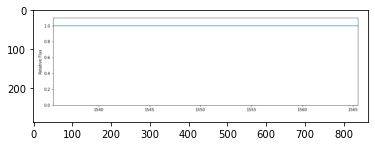

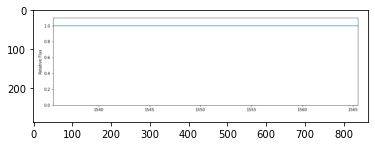

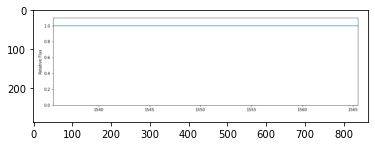

In [19]:
# Constituent spectra
for j, density_j in enumerate( density ):
    plt.imshow( mpimg.imread( './debug/spectrum_{}_{}.png'.format( i, j ) ) )
    plt.show()

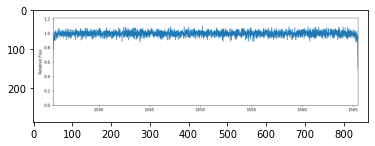

In [20]:
# Final spectra most recently produced
plt.imshow( mpimg.imread( './debug/spectrum_sl{:04d}.png'.format( i ) ) )

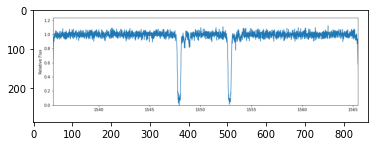

In [21]:
# Spectra given to observers
plt.imshow( mpimg.imread( './debug/spectrum_MgII_sl{:04d}.png'.format( i ) ) )

Looks good (*IF* N V is included, which was contaminating)! Now why is it so intense?

In [22]:
j = 0

In [23]:
( density[j] / u.mp ).to( 'cm**-3' ), temperature[j], metallicity[j]

(unyt_quantity(0.00011185, 'cm**(-3)'),
 unyt_quantity(142130.26015636, 'K'),
 unyt_quantity(52.72293522, 'Zsun'))

Woah! Look at that metallicity! Let's compare it to the simulation metallicity distribution.

In [25]:
ii = copy.copy( i )
jj = copy.copy( j )

In [26]:
f = h5py.File( distribution_fp, 'r' )
param_labels = [ 'Temperature', 'Density', 'Metallicity', 'HI Column' ]

In [27]:
# Get centers, reformat edges

histogram_axes = [ 'Temperature', 'Density', 'Metallicity', 'hneutralssh' ]
centers = []
bins = []
dxs = []
for i, key in enumerate( histogram_axes ):
    
    arr = copy.copy( f['histogram_axes'][key][...] )
    dx = arr[2] - arr[1]
    
    # For convenience, let's not have a -inf edge lying around
    if key == 'Metallicity':
        arr[0] = arr[1] - dx
        
    centers_i = arr[:-1] + 0.5 * dx
    
    dxs.append( dx )
    centers.append( centers_i )
    bins.append( arr )

In [28]:
# Normalize into a pdf

norm = f['histogram'][...].sum() * dxs[0] * dxs[1] * dxs[2] * dxs[3]
pdf = f['histogram'][...] / norm

In [29]:
# Set up combinations to iterate through
inds = range( len( histogram_axes ) )
combinations = [ _ for _ in itertools.combinations( inds, 2 ) ]

In [30]:
phase_diagram = verdict.Dict.from_hdf5( './data/m12i_phase_diagram_z0.25.h5' )

<ipython-input-31-c80981e2a19f>:16: RuntimeWarning: divide by zero encountered in log10
  np.log10( projection ),


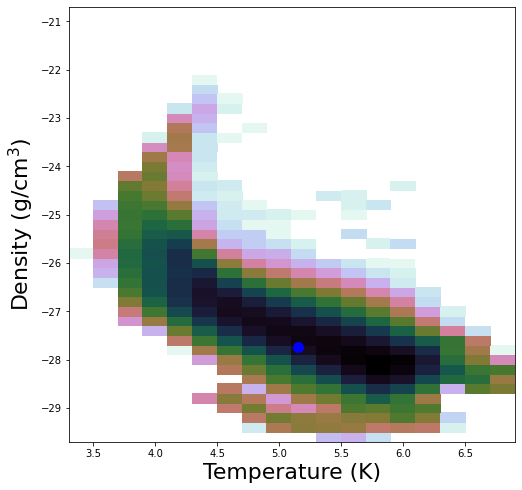

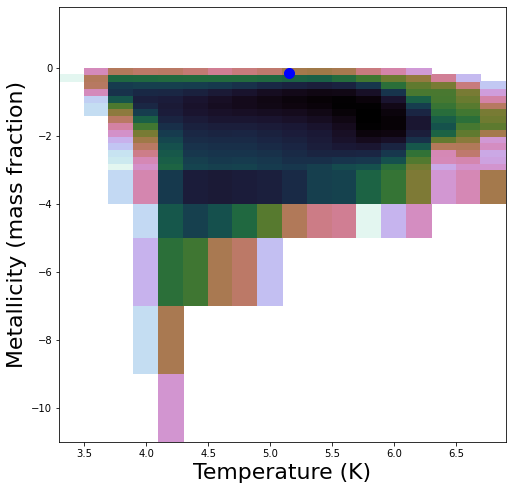

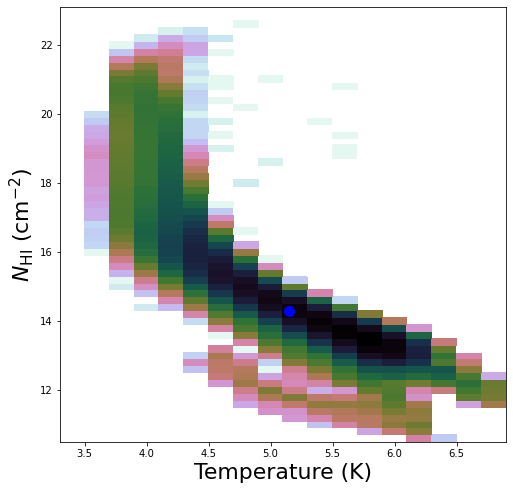

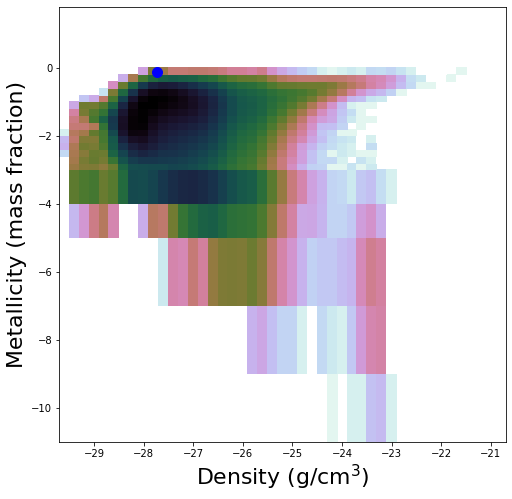

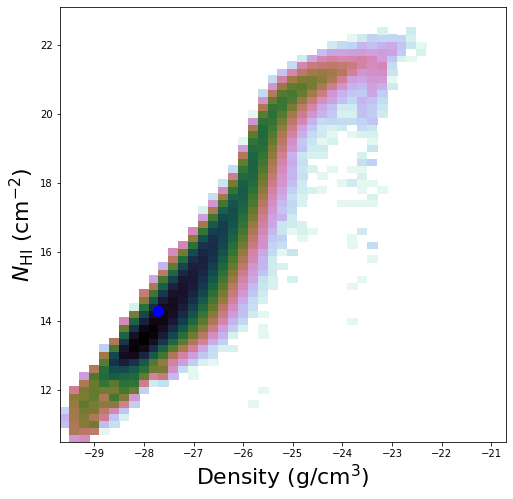

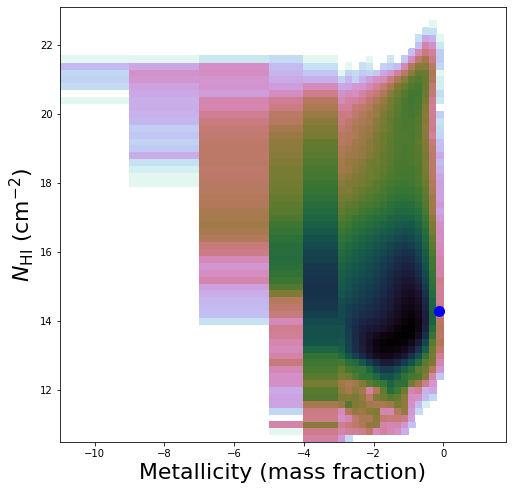

In [31]:
labels = [ 'Temperature (K)', r'Density (g/cm$^{3}$)', 'Metallicity (mass fraction)', r'$N_{\rm HI}$ (cm$^{-2}$)' ]
for k, (i, j) in enumerate( combinations ):
    
    # Show data
    fig = plt.figure( figsize=(8,8), facecolor='w' )
    ax = plt.gca()

    sum_axes = copy.copy( list( inds ) )
    sum_axes.remove( i )
    sum_axes.remove( j )
    projection = pdf.sum( axis=tuple( sum_axes ) ).transpose()
    x, y = np.meshgrid( centers[i], centers[j] )
    ax.pcolormesh(
        centers[i],
        centers[j],
        np.log10( projection ),
        cmap = 'cubehelix_r',
    )
    
    ax.scatter(
        sls[param_labels[i]][ii][jj],
        sls[param_labels[j]][ii][jj],
        color = 'blue',
        s = 100,
    )

    
    ax.set_xlabel( labels[i], fontsize=22 )
    ax.set_ylabel( labels[j], fontsize=22 )
    
    ax.set_aspect( 'auto' )
    
    plt.savefig(
        './figures/sample1/clouddist_{}_{}.png'.format(
            param_labels[i].replace( ' ', '' ),
            param_labels[j].replace( ' ', '' )
        ),
        bbox_inches = 'tight',
    )

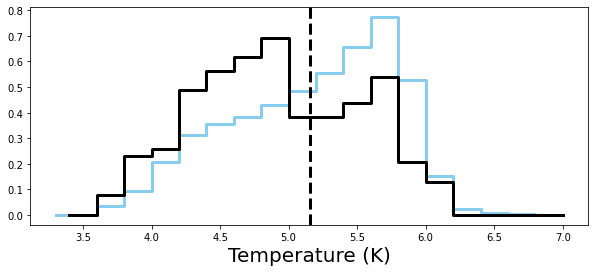

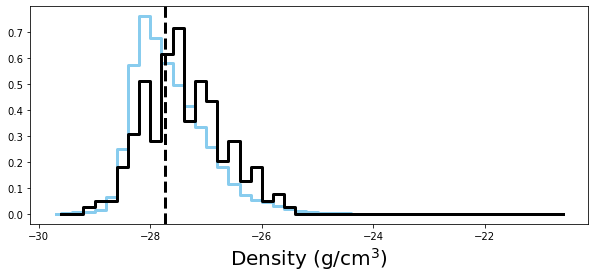

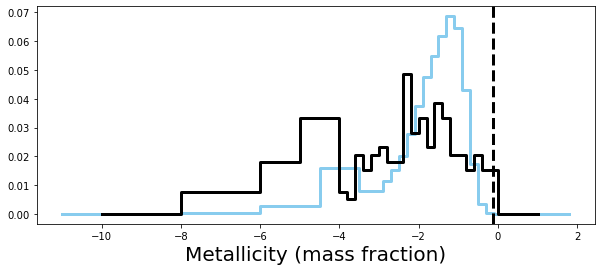

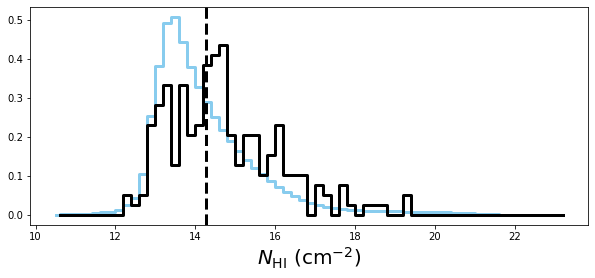

In [32]:
# 1D histograms
for i, param_label in enumerate( param_labels ):
    
    fig = plt.figure( figsize=(10,4), facecolor='w' )
    ax = plt.gca()
    
    sum_axes = copy.copy( list( inds ) )
    sum_axes.remove( i )
    projection = pdf.sum( axis=tuple( sum_axes ) )
    projection /= projection.sum() * dxs[i]
    
    ax.step(
        centers[i],
        projection,
        where = 'mid',
        color = palettable.cartocolors.qualitative.Safe_10.mpl_colors[0],
        linewidth = 3,
    )
    
    # For convenience, let's not have a -inf edge lying around
    used_bins = copy.copy( bins[i] )
    if param_label == 'Metallicity':
        used_bins[-1] = 1.0001
    
    hist, used_bins = np.histogram(
        clouds[param_labels[i]],
        bins = used_bins,
    )
    hist =  hist / ( hist.sum() * dxs[i] )
    ax.step(
        used_bins[1:],
        hist,
        where = 'pre',
        color = 'k',
        linewidth = 3,
    )
    
    ax.axvline(
        sls[param_label][ii][jj],
        color = 'k',
        linewidth = 3,
        linestyle = '--',
    )
    
    ax.set_xlabel( labels[i], fontsize=20 )

Consistent with the metallicity distribution. Asking Nastasha how such enriched gas is produced in the EAGLE sims.

## Check Sameer and Jane's First Results

In [147]:
indices = [ 5, 71, 76, ]

In [148]:
den_comb = []
met_comb = []
temp_comb = []
for i in indices:
    
    print( 'Sightline {:03d}'.format( i ) )

    density = 10.**sls['Density'][i] * u.g * u.cm**-3 / u.mp * 0.75
    temperature = 10.**sls['Temperature'][i] * u.K
    metallicity = 10.**sls['Metallicity'][i] / Z_sun
    HI_column = 10.**sls['HI Column'][i] * u.cm**-2
    velocity = sls['LOS Velocity'][i] * u.km / u.s
    lengths = sls['Lengths'][i] * u.cm
    
    for j, den in enumerate( density ):
        
        print( '    logZ = {:.3g}, logT = {:.3g}, logn = {:.3g}'.format( 
                np.log10( metallicity[j] ),
                np.log10( temperature[j] ),
                np.log10( den ),
            )
        )

    if len( velocity ) == 2:
        print( '    delta_v = {:.3g}'.format( np.abs( velocity[1] - velocity[0] ) ) )
    
    den = ( density * lengths ).sum() / lengths.sum()
    temp = ( temperature * density * lengths ).sum() / ( density * lengths ).sum()
    met = ( metallicity * Z_sun * density * lengths ).sum() / ( Z_sun * density * lengths ).sum()
    print( '    Combined, logZ = {:.3g}, logT = {:.3g}, logn = {:.3g}'.format( 
            np.log10( met ),
            np.log10( temp ),
            np.log10( den ),
        )
    )
    
    den_comb.append( den )
    met_comb.append( met )
    temp_comb.append( temp )

Sightline 005
    logZ = -1.2, logT = 5.45, logn = -4.36
    logZ = 1.53, logT = 4.69, logn = -2.83
    delta_v = 11 km/s
    Combined, logZ = 1.19, logT = 5.25, logn = -4.11
Sightline 071
    logZ = -0.0743, logT = 4.47, logn = -3.13
    logZ = -1.56, logT = 5.67, logn = -4.07
    delta_v = 30.3 km/s
    Combined, logZ = -0.571, logT = 5.53, logn = -3.93
Sightline 076
    logZ = 0.922, logT = 4.53, logn = -4.07
    logZ = -1.22, logT = 5.01, logn = -3.57
    delta_v = 19.3 km/s
    Combined, logZ = -0.8, logT = 5.01, logn = -3.58


In [89]:
indices

array([ 5, 10, 22, 28, 34, 46, 50, 71, 76, 97])

In [149]:
sameer_charlton = {
    5: {
        'Density': [ ( -2.21, 0.49, 0.21 ), ( -4.83, 4.10, 1.13) ],
        'Temperature': [ ( 4.76, 0.02, 0.02 ), ( 5.48, 0.22, 1.74 ) ],
        'Metallicity': [ ( 1.14, 0.08, 0.08 ), ( 0.11, 1.25, 1.63 ) ],
    },
    71: {
        'Density': [ ( -3.11, 0.16, 0.11 ), ],
        'Temperature': [ ( 4.50, 0.01, 0.02 ), ],
        'Metallicity': [ ( 0.06, 0.09, 0.09 ), ],
    },
    76: {
        'Density': [ ( -3.55, 0.24, 0.21 ), ( -3.46, 0.44, 0.29), ( -5.73, 0.59, 0.26) ],
        'Temperature': [ ( 4.88, 0.07, 0.10 ), ( 5.00, 0.04, -0.04 ), (4.42, 0.5, 0.79, ) ],
        'Metallicity': [ ( 0.58, 0.78, 0.85 ), ( -1.40, 0.18, 0.23), ( -0.55, 1.77, 0.45 ) ],
    },
}

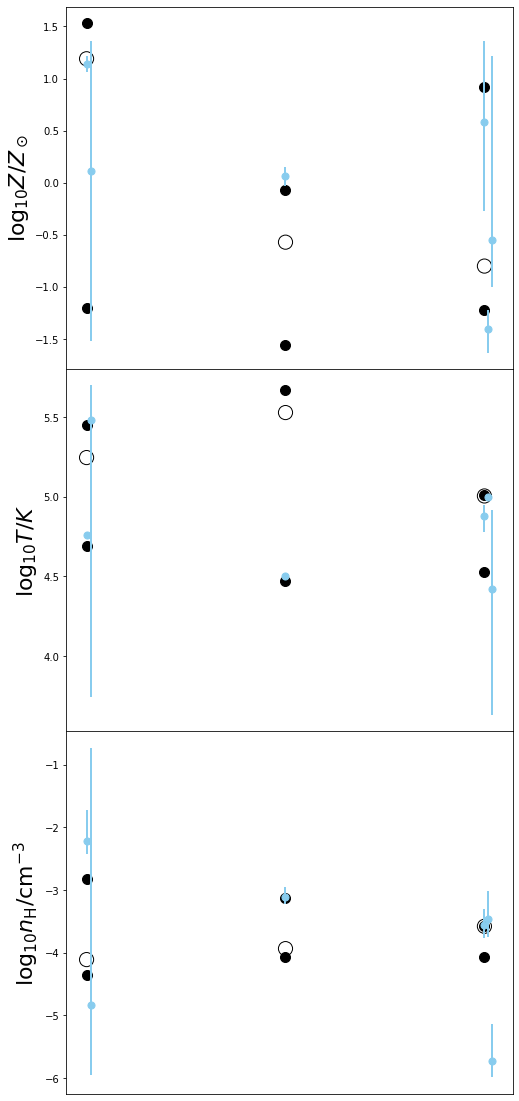

In [157]:
fig = plt.figure( figsize=(8,20), facecolor='w' )
# ax_main = plt.gca()

gs = matplotlib.gridspec.GridSpec( 3, 1 )

main_xs = np.arange( len( indices ) ) + 1

### Metallicity ############################
ax = fig.add_subplot( gs[0,0] )

# Combined
ax.scatter(
    main_xs,
    np.log10( met_comb ),
    color = 'none',
    edgecolor = 'k',
    s = 200,
)

gs.update( hspace=0.0001)

# Individual clouds
for i, ind in enumerate( indices ):
    
    ys = np.log10( 10.**sls['Metallicity'][ind] / Z_sun )
    val_sc = np.array( sameer_charlton[ind]['Metallicity'] )
    ys_sc = val_sc[:,0]
    
    xs = np.full( ys.size, i+1 )
    ax.scatter(
        xs,
        ys,
        color = 'k',
        s = 100,
        zorder = 0,
    )
    

    xs = np.full( ys_sc.size, i+1 )
    # Add some offset
    if xs.size > 1:
        xs = xs + np.arange( xs.size ) * 0.02
    ax.scatter(
        xs,
        ys_sc,
        color = colormap[0],
        s = 50,
        zorder = 10,
    )
    ax.errorbar(
        xs,
        ys_sc,
        yerr = val_sc[:,[1,2]].transpose()[::-1],
        color = colormap[0],
        zorder = 9,
        linewidth = 0,
        elinewidth = 2,
    )
    
    ax.set_ylabel( r'$\log_{10} Z / Z_\odot$', fontsize=22 )
    
    ax.tick_params( axis='x', bottom=False, labelbottom=False )
    
### Temperature ############################
ax = fig.add_subplot( gs[1,0] )

# Combined
ax.scatter(
    main_xs,
    np.log10( temp_comb ),
    color = 'none',
    edgecolor = 'k',
    s = 200,
)

# Individual clouds
for i, ind in enumerate( indices ):
    
    ys = sls['Temperature'][ind]
    val_sc = np.array( sameer_charlton[ind]['Temperature'] )
    ys_sc = val_sc[:,0]
    
    xs = np.full( ys.size, i+1 )
    ax.scatter(
        xs,
        ys,
        color = 'k',
        s = 100,
        zorder = 0,
    )
    

    xs = np.full( ys_sc.size, i+1 )
    # Add some offset
    if xs.size > 1:
        xs = xs + np.arange( xs.size ) * 0.02
    ax.scatter(
        xs,
        ys_sc,
        color = colormap[0],
        s = 50,
        zorder = 10,
    )
    ax.errorbar(
        xs,
        ys_sc,
        yerr = val_sc[:,[1,2]].transpose()[::-1],
        color = colormap[0],
        zorder = 9,
        linewidth = 0,
        elinewidth = 2,
    )
    
    ax.set_ylabel( r'$\log_{10} T / K$', fontsize=22 )
    
    ax.tick_params( axis='x', bottom=False, labelbottom=False )

    
### Density ############################
ax = fig.add_subplot( gs[2,0] )

# Combined
ax.scatter(
    main_xs,
    np.log10( den_comb ),
    color = 'none',
    edgecolor = 'k',
    s = 200,
)

# Individual clouds
for i, ind in enumerate( indices ):
    
    ys = np.log10( 10.**sls['Density'][ind] * u.g * u.cm**-3 / u.mp * 0.75 )
    val_sc = np.array( sameer_charlton[ind]['Density'] )
    ys_sc = val_sc[:,0]
    
    xs = np.full( ys.size, i+1 )
    ax.scatter(
        xs,
        ys,
        color = 'k',
        s = 100,
        zorder = 0,
    )
    

    xs = np.full( ys_sc.size, i+1 )
    # Add some offset
    if xs.size > 1:
        xs = xs + np.arange( xs.size ) * 0.02
    ax.scatter(
        xs,
        ys_sc,
        color = colormap[0],
        s = 50,
        zorder = 10,
    )
    ax.errorbar(
        xs,
        ys_sc,
        yerr = val_sc[:,[1,2]].transpose()[::-1],
        color = colormap[0],
        zorder = 9,
        linewidth = 0,
        elinewidth = 2,
    )
    
    ax.set_ylabel( r'$\log_{10} n_{\rm H} / {\rm cm}^{-3}$', fontsize=22 )
    
    ax.tick_params( axis='x', bottom=False, labelbottom=False )

# Some Listed Lines are Actually Outside Observable Range

In [ ]:
suspect_ions =  [ 'Si III', 'Si IV', 'N V' ]

In [ ]:
def print_observable_redshifts( ion_list ):

    for ion in ion_list:

        print( ion )

        lines = ldb.select_lines( *ion.split( ' ' ) )

        for i, line in enumerate( lines ):
            lambda_rest = line.wavelength * u.angstrom
            min_z = sg_cos.lambda_min / lambda_rest  - 1.
            max_z = sg_cos.lambda_max / lambda_rest  - 1.

            print( '    {} observable redshifts = [{:.2g}, {:.2g}]'.format( lambda_rest, min_z, max_z ) )

In [ ]:
print_observable_redshifts( suspect_ions )

In [ ]:
print_observable_redshifts( ions )